In this lab, you are supposed to do the following tasks related to Gaussian process.

1. Sampling of a Gaussian process.
2. Regression with a Gaussian process.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Setup
Let's first import the necessary libraries and set a random seed.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

np.random.seed(666)

plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 20})

# Pre-task: Generate a dataset

Since we will deal with a regression problem, let us first generate a synthetic dataset. This dataset comprises a function $t\mapsto f(t)$ that we aim to estimate and some noisy observations of it at some time points.

This implementation is done for you; **do not** change anything here.

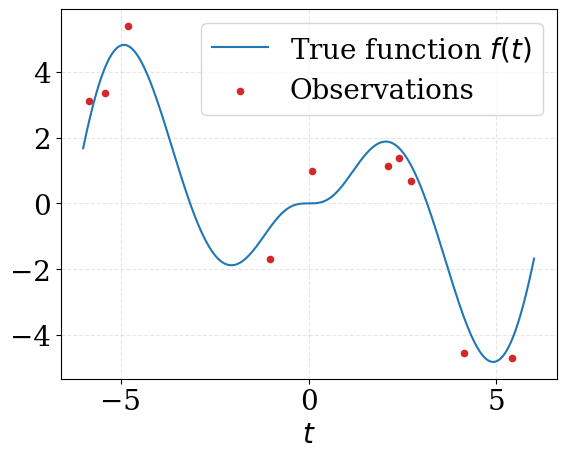

In [28]:
def f(t):
    return t * np.sin(t * np.tanh(t))


ndata = 10  # number of data points
xi = 1.  # noise variance

data_ts = np.sort(np.random.uniform(-6, 6, ndata))  # the time steps at which we observe the data
data_fs = f(data_ts)
data_ys = data_fs + xi ** 0.5 * np.random.randn(ndata)  # the data we observe

n = 1000
ts = np.linspace(-6, 6, n)

fig, ax = plt.subplots()
_ = ax.plot(ts, f(ts), c='tab:blue', label=r'True function $f(t)$')
_ = ax.scatter(data_ts, data_ys, s=20, c='tab:red', label='Observations')
ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()
_ = ax.set_xlabel('$t$')

Our goal is to estimate the function $f$ based on the data shown as the red points in the figure above. We will use a Gaussian process to do this.

# Task 1: Define a Gaussian process and draw samples from it

A rule of thumb: always take a look at the data first (i.e., exploratory data analysis) and then define your model. Ideally, you should also consider the prior knowledge you have about the problem at hand, so as to come up with a good model.

However, since this example is just a synthetic dataset, and let us assume that we have a prior knowledge that the function we want to estimate is smooth.
Based on this prior knowledge, we can define a Gaussian process with a squared exponential covariance function (also known as the radial basis function). The parameters $\ell$ and $\sigma$ are given to you.

An inspection of the data tells us that probably the function has a mean around zero, so we can set the mean function to be zero.

Now implement the mean $m$ and covariance functions $C$ that comprise the Gaussian process:

$$
f \sim \mathrm{GP}(m, C),
$$

where

$$
\begin{equation}
\begin{split}
m(t) &= 0, \\
C(t, s) &= \sigma^2 \exp\bigg(-\frac{(t - s)^2}{\ell}\bigg).
\end{split}
\end{equation}
$$

In [29]:
ell, sigma = 5., 1.8


def mean_fn(t: np.ndarray) -> np.ndarray:
    r"""Mean function m of the Gaussian process t \mapsto E[f(t)].

    Parameters
    ----------
    t : (...)
        Time steps at which to evaluate the mean function.

    Returns
    -------
    (...)
        The mean values.
    """
    return np.zeros_like(t)


def cov_fn(t: np.ndarray, s: np.ndarray) -> np.ndarray:
    r"""Covariance function C of the Gaussian process. This should compute (t, s) \mapsto Cov[f(t), f(s)].

    Parameters
    ----------
    t : (n, )
        Time steps at which to evaluate the covariance function.
    s : (m, )
        Time steps at which to evaluate the covariance function.

    Returns
    -------
    (n, m)
        Covariance matrix between the time steps `t` and `s`. Each element of this matrix should give C(t_i, s_j).
    """
    t = t.reshape(-1, 1)
    s = s.reshape(1, -1)
    return sigma**2 * np.exp(-(t - s)**2 / ell)

Now a GP has been defined, we can draw samples from it. Say we want to draw $f_{0:n} = \begin{bmatrix} f(t_0) & \cdots & f(t_n)\end{bmatrix}$, then

$$
f_{0:n}\sim \mathrm{N}(m_{0:n}, C_{0:n, 0:n}),
$$

where $m_{0:n} = \begin{bmatrix} m(t_0) & \cdots & m(t_n)\end{bmatrix}$ is the mean vector and $C_{0:n, 0:n}$ is the covariance matrix with entries $C_{i,j} = C(t_i, t_j)$.

Draw 10 independent samples and let `n=1000`.

### Note

You may encounter numerical issues with the RBF covariance function. Jitter the covariance matrix by adding a small value to the diagonal. This is a common practice in Gaussian processes to ensure numerical stability.

In [30]:
# Compute the mean vector at the time steps `ts`
gp_mean = mean_fn(ts)

# Compute the covariance matrix at the time steps `ts`
# The later diagonal addition is a jittering; try removing it to see what happens
gp_cov = cov_fn(ts, ts) + np.eye(1000) * 1e-6
samples = np.zeros((10, n))  # 10 samples, each of size 1000
for i in range(10):
    samples[i] = np.random.multivariate_normal(gp_mean, gp_cov)

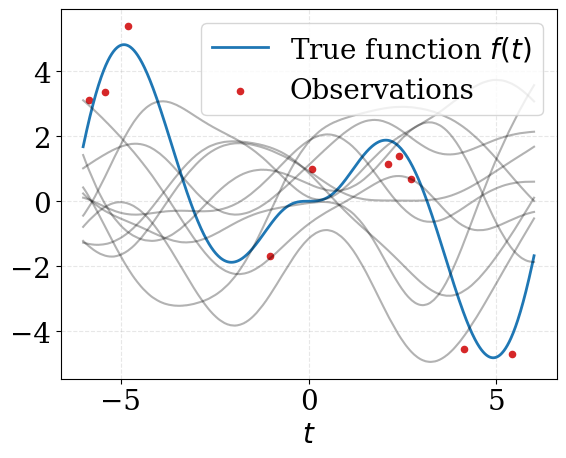

In [31]:
fig, ax = plt.subplots()
_ = ax.plot(ts, f(ts), c='tab:blue', linewidth=2, label=r'True function $f(t)$')
for i in range(10):
    _ = ax.plot(ts, samples[i], c='black', alpha=.3)
_ = ax.scatter(data_ts, data_ys, c='tab:red', s=20, label='Observations')
ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()
_ = ax.set_xlabel('$t$')

# Question 1

By looking at the GP samples (grey lines in the figure above), do you agree or disagree if this GP is a good prior for the function we want to model? Why? What if you change the parameters $\ell$ and $\sigma$?


# Answer

Agree - Based on the GP samples we can see most of the functions follow the true function patterns. We can see sample GPs have the similar smoothness and similar amplitude as the true function. Also they have proper oscillation pattern as the true function





# Question 3

Is Cholesky decomposition the fastest algorithm for sampling a GP? Is it possible to be faster? Give some examples sampling algorithms.

# Answer

No, Cholesky is not the fastest. It has O(n³) complexity.

Faster algorithms:

1. Circulant embedding - O(n log n)
2. Random Fourier Features – O(nr)


# Task 2: Gaussian process regression

Recall the dataset we just generated `data_ts`, `data_ys`, standing for $t_{0:n}$ and $y_{0:n}$, respectively. The GP regression aims to estimate the function $f(t)$ at any arbitrary test time point $t$ in terms of posterior distribution:

$$
p(f_{0:s}^* \mid y_{0:n}),
$$

where $f_{0:s}^* = \begin{bmatrix} f_{t^*_0} & \cdots & f_{t^*_s} \end{bmatrix}$ is the function at the $s$ test points $t^*_{0:s}$.
This distribution is a Gaussian and its mean and covariance is available in closed form (see the lecture notes for details).
You are asked to make implementations to compute the posterior mean and covariance.

In [32]:
ntest = 1000

test_ts = np.linspace(-7., 7., ntest)  # This is f star

C_star_star = cov_fn(test_ts, test_ts)
C_star_data = cov_fn(test_ts, data_ts)
C_data_data = cov_fn(data_ts, data_ts)
C_y = C_data_data + xi * np.eye(ndata)

# Mean at test and training points
m_star = mean_fn(test_ts)
m_data = mean_fn(data_ts)


C_y_inv_times_diff = np.linalg.solve(C_y, data_ys - m_data)

# The shape should be (ntest, )
posterior_mean = m_star + C_star_data @ C_y_inv_times_diff


C_y_inv_times_C_data_star = np.linalg.solve(C_y, C_star_data.T)

# The shape should be (ntest, ntest)
posterior_cov = C_star_star - C_star_data @ C_y_inv_times_C_data_star


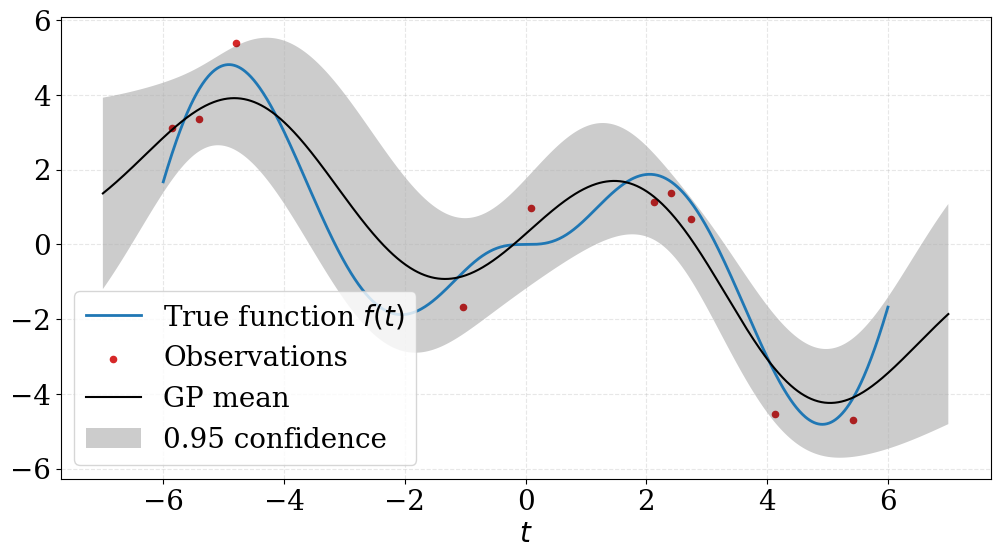

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = ax.plot(ts, f(ts), c='tab:blue', linewidth=2, label=r'True function $f(t)$')
_ = ax.scatter(data_ts, data_ys, s=20, c='tab:red', label='Observations')
_ = ax.plot(test_ts, posterior_mean, c='black', label='GP mean')
_ = ax.fill_between(test_ts,
                    posterior_mean - 1.96 * np.diag(posterior_cov) ** 0.5,
                    posterior_mean + 1.96 * np.diag(posterior_cov) ** 0.5,
                    color='black',
                    edgecolor='none',
                    alpha=0.2,
                    label='0.95 confidence')
ax.grid(linestyle='--', alpha=0.3, which='both')
_ = ax.legend()
_ = ax.set_xlabel('$t$')

# Question 4

Analyse the results shown in the figure above. This is an open discussion, no standard answer, but your statement should be true.

# Answer

The GP mean function is very close to the data points. That means GP regression doing it job. But GP mean has some variations from true function as data points are noisy.

Also we can see in are between -6 , +6 has a narrow CI bands(interpolation region) while it has wide bands outside that region(extrapolation region)

# Question 5
An interesting observation: the posterior covariance *does not* depend on the data values `data_ys`, meaning that the uncertainty quantification does not use the actual data values, but only where the data points are located `data_ts`. Why is that? Is this a good or bad property? Discuss.

# Answer

The posterior covariance only depends on the data locations (data_ts) because it reflects where we have information, not what the observed values are. It measures uncertainty based on input spacing. This is a good property,the GP’s confidence depends on how well the input space is covered, not on noisy output values.



# Contribution statement

This assignment was completed as a team effort with equal contributions from Xiaochen and Nisal. Xiaochen is responsible for task 1, Nisal is responsible for task 2.


